# **Transformar with sentiment**

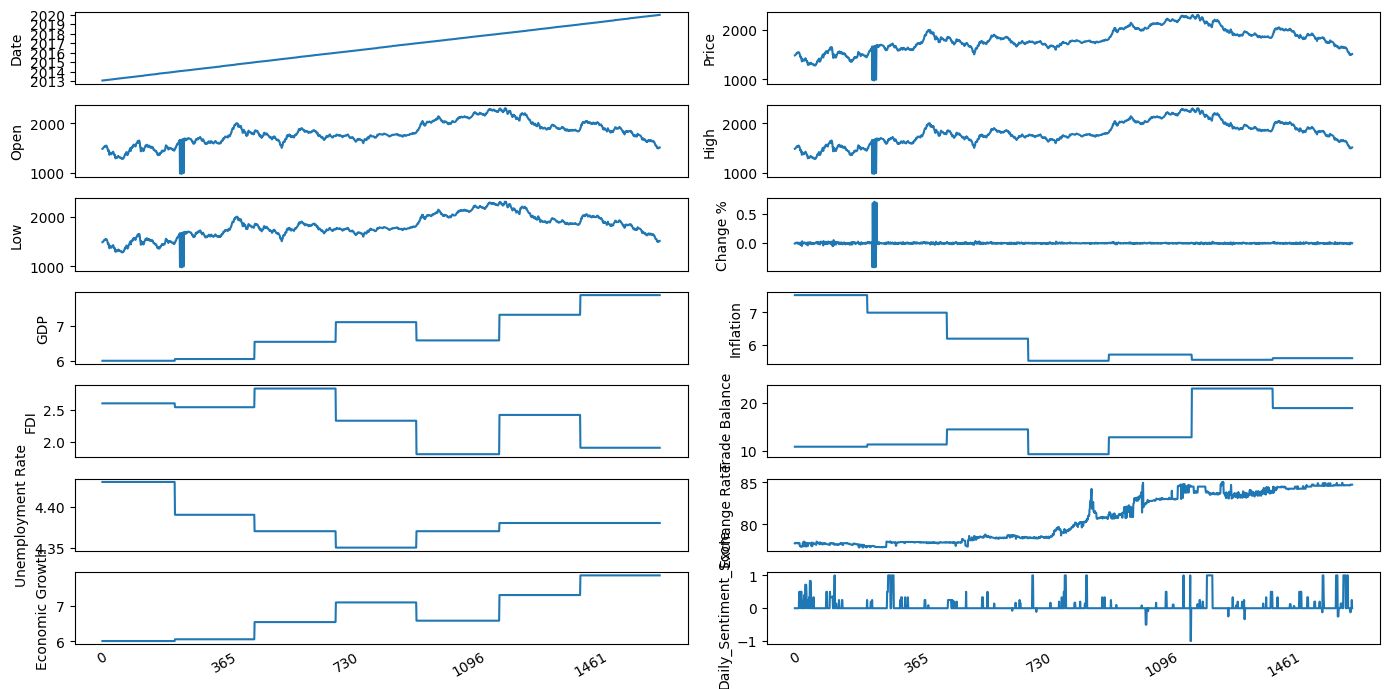

Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 19s 227ms/step - loss: 0.0957 - val_loss: 0.0082 - learning_rate: 0.0010
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 7s 155ms/step - loss: 0.0144 - val_loss: 0.0235 - learning_rate: 0.0010
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 8s 220ms/step - loss: 0.0126 - val_loss: 0.0103 - learning_rate: 0.0010
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 315ms/step - loss: 0.0082 - val_loss: 0.0163 - learning_rate: 0.0010
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 11s 292ms/step - loss: 0.0076 - val_loss: 0.0137 - learning_rate: 2.0000e-04
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 17s 204ms/step - loss: 0.0065 - val_loss: 0.0107 - learning_rate: 2.0000e-04
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 183ms/step - loss: 0.0068 - val_loss: 0.0179 - learning_rate: 2.0000e-04
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 9s 158ms/step - loss: 0.0066 - val_loss: 0.0127 - learning_rate: 1.0000e-04
Epoch 9/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 12s 193ms/step - loss: 0.0076 - val_loss: 0.0119 - learning_ra

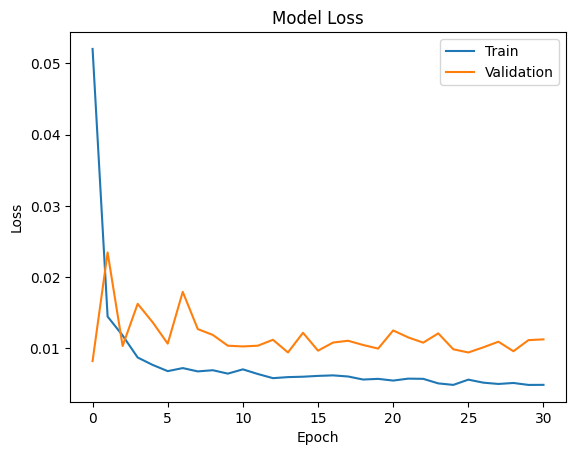

11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 172ms/step
Mean Squared Error (MSE): 34038.87
Root Mean Squared Error (RMSE): 184.50
Mean Absolute Error (MAE): 146.23
Mean Absolute Percentage Error (MAPE): 8.41%


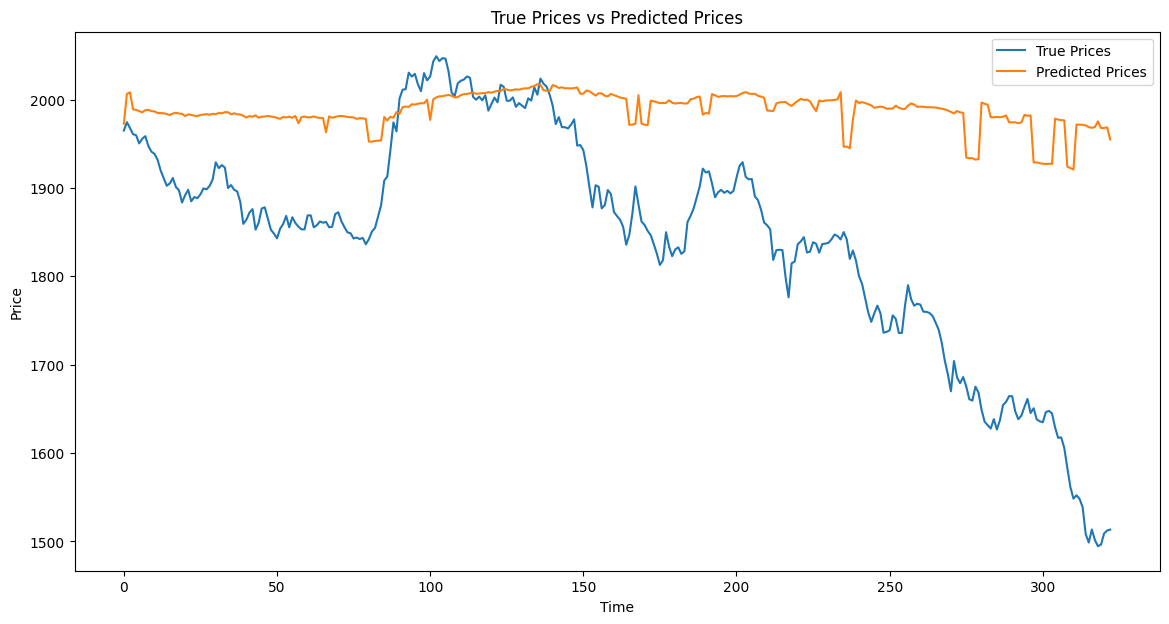

Accuracy of Predicted Prices: 73.63%


In [ ]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import math
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Model
from keras.optimizers import Adam
from keras.layers import Input, Dense, Dropout, LayerNormalization, MultiHeadAttention, Add, TimeDistributed, Conv1D
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Set random seed for NumPy
np.random.seed(42)

# Set random seed for TensorFlow
tf.random.set_seed(42)

# Set random seed for Python random module
random.seed(42)

# Read the CSV file and sort by date
df = pd.read_csv('13=19.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by='Date').reset_index(drop=True)
df.dropna(inplace=True)

# Plot line charts
df_plot = df.copy()
ncols = 2
nrows = int(round(df_plot.shape[1] / ncols, 0))
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(14, 7))
for i, ax in enumerate(fig.axes):
    sns.lineplot(data=df_plot.iloc[:, i], ax=ax)
    ax.tick_params(axis="x", rotation=30, labelsize=10, length=0)
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
fig.tight_layout()
plt.show()

# List of considered Features
FEATURES = ['Price', 'Open', 'High', 'Low', 'GDP', 'Inflation', 'FDI', 'Trade Balance',
            'Unemployment Rate', 'Exchange Rate', 'Economic Growth','Daily_Sentiment_Score']

# Create the dataset with features and filter the data to the list of FEATURES
data_filtered = df[FEATURES]

# Scaling data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data_filtered)

# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 50

# Generate training data and test data
def partition_dataset(sequence_length, data):
    x, y = [], []
    for i in range(sequence_length, len(data)):
        x.append(data[i-sequence_length:i, :])
        y.append(data[i, 0])  # Prediction is based on the 'Price' column
    return np.array(x), np.array(y)

# Generate training and test data
x, y = partition_dataset(sequence_length, data_scaled)
split = math.ceil(0.8 * len(x))
x_train, y_train = x[:split], y[:split]
x_test, y_test = x[split:], y[split:]

# Define Transformer Block
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Multi-Head Attention
    attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=head_size)(inputs, inputs)
    attention_output = Dropout(dropout)(attention_output)
    attention_output = Add()([inputs, attention_output])
    attention_output = LayerNormalization(epsilon=1e-6)(attention_output)

    # Feed Forward Network
    ff_output = Dense(ff_dim, activation="relu")(attention_output)
    ff_output = Dropout(dropout)(ff_output)
    ff_output = Dense(inputs.shape[-1])(ff_output)
    ff_output = Add()([attention_output, ff_output])
    return LayerNormalization(epsilon=1e-6)(ff_output)

# Input layer
inputs = Input(shape=(x_train.shape[1], x_train.shape[2]))

# Apply the transformer encoder with multiple heads
x = transformer_encoder(inputs, head_size=256, num_heads=4, ff_dim=128, dropout=0.15)
x = transformer_encoder(x, head_size=128, num_heads=4, ff_dim=64, dropout=0.15)

# Flatten output and pass through dense layers for regression
x = TimeDistributed(Dense(32, activation="relu"))(x)
x = Dropout(0.15)(x)
x = Conv1D(64, kernel_size=1, activation="relu")(x)
outputs = Dense(1)(x[:, -1, :])

# Build the model
model = Model(inputs, outputs)

# Compile the model
optimizer = Adam(clipvalue=1.0)  # Adjust learning rate as needed
model.compile(optimizer=optimizer, loss='mse')

# Define callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=30, verbose=1, mode='min', restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)

# Training the model
history = model.fit(x_train, y_train, epochs=50, batch_size=32, validation_split=0.1, callbacks=[early_stop, reduce_lr])

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Get the predicted values
y_pred_scaled = model.predict(x_test)
y_pred = scaler.inverse_transform(np.concatenate((y_pred_scaled, x_test[:, -1, 1:]), axis=1))[:, 0]
y_test_unscaled = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), x_test[:, -1, 1:]), axis=1))[:, 0]

# Calculate metrics
mse = mean_squared_error(y_test_unscaled, y_pred)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_test_unscaled - y_pred))
mape = np.mean(np.abs((y_test_unscaled - y_pred) / y_test_unscaled)) * 100

print(f'Mean Squared Error (MSE): {mse:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')
print(f'Mean Absolute Error (MAE): {mae:.2f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')

# Plot true prices and predicted prices
plt.figure(figsize=(14, 7))
plt.plot(y_test_unscaled, label='True Prices')
plt.plot(y_pred, label='Predicted Prices')
plt.title('True Prices vs Predicted Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

# Calculate accuracy of predicted prices
absolute_difference = np.abs(y_test_unscaled - y_pred)
mean_absolute_difference = np.mean(absolute_difference)
price_range = np.max(y_test_unscaled) - np.min(y_test_unscaled)
accuracy_percentage = (1 - (mean_absolute_difference / price_range)) * 100
print(f'Accuracy of Predicted Prices: {accuracy_percentage:.2f}%')
